In [1]:
import autograd.numpy as np
from autograd import grad
import matplotlib.pyplot as plt
from scipy.stats import qmc
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Definicoes Iniciais

Os trechos de código a seguir foram criados para o artigo/trabalho da disciplina **Inteligência Computacional** no período do 1º Quadrimestre de 2025 na Universidade Federal do ABC.


## Funcoes de Ativação

Algumas funções de ativação que podem ser utilizadas dentro da rede.

In [ ]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def my_tanh(x):
  return np.tanh(x)

def my_cos(x):
  return np.cos(x)

def sin_tanh(x):
  return np.sin(x) + x*np.tanh(x)

def cos_sig(x):
  return np.cos(x)/sigmoid(x)

## Rede Neural

Aqui é apresentado a função usada para criar uma rede neural genérica, essa função é chamada dentro do problema das PINNs para ter seus pesos otimizados.

In [ ]:
# Função que calcula Y = Y1 + Y2
def my_NN(x, params,N_INPUT,N_OUTPUT,N_NEURON,N_HIDDEN):
    # par_input = params[0][:N_NEURON*(N_INPUT+1)]
    # par_hidden = params[0][N_NEURON*(N_INPUT+1):-N_OUTPUT*(N_NEURON+1)]
    # par_output = params[0][-N_OUTPUT*(N_NEURON+1):]
    par_input = params[:N_NEURON*(N_INPUT+1)]
    par_hidden = params[N_NEURON*(N_INPUT+1):-N_OUTPUT*(N_NEURON+1)]
    par_output = params[-N_OUTPUT*(N_NEURON+1):]
    z_input = x*par_input[:N_NEURON] + par_input[N_NEURON:]

    #ativacao = my_tanh  #Definindo a funcao de ativacao
    ativacao = sigmoid

    y_input = ativacao(z_input)
    #print(y_input)
    if N_HIDDEN > 1:
      for i in range(N_HIDDEN-1):
        # fatia = np.size(par_hidden)//(N_HIDDEN-1)
        # new_par_hidden = par_hidden[i * fatia : (i + 1) * fatia]
        # pesos = new_par_hidden[:N_NEURON**2]
        # vies = new_par_hidden[N_NEURON**2:]
        # new_pesos = pesos.reshape(N_NEURON,N_NEURON)
        fatia = np.size(par_hidden)//(N_HIDDEN-1)                 #numero de cortes no vetor de parametros
        new_par_hidden = par_hidden[i * fatia : (i + 1) * fatia]  #dados para somente uma camada
        pesos = new_par_hidden[:N_NEURON**2]                      #pesos de uma unica camada
        vies = new_par_hidden[N_NEURON**2:]                       #bias de uma unica camada
        new_pesos = pesos.reshape(N_NEURON,N_NEURON)              #colocando os pesos em forma de uma matriz
        #print(new_pesos)
        #print(vies)
        if i == 0:
          y_hidden = ativacao(y_input @ new_pesos + vies)         #calculando os y que vao sair da primeira camada hidden
          #print(y_hidden)
        else:
          y_hidden = ativacao(y_hidden @ new_pesos + vies)        #calculando os y que vao sair das demais camadas hidden
          #print(y_hidden)
        #print('')
    else:
      y_hidden = y_input

    y_output = y_hidden @ par_output[:N_NEURON] + par_output[N_NEURON:]

    return y_output


## Evolucao Diferencial

In [ ]:
def DE_alg(Func, X_max, X_min, N, M, I_max, F, CR, x, Fitness):
    Kmax = I_max  # Número máximo de iterações
    dim = N  # Número de dimensões

    # Limites do espaço de busca
    lb = np.array(X_min)
    ub = np.array(X_max)

    X = np.array(x)
    fitnessXbest = np.min(Fitness)
    I = np.argmin(Fitness)
    xBest = X[I, :].copy()
    converg_curve = np.zeros(I_max)
    evaluations = 1

    # Processo iterativo
    while evaluations <= Kmax:
        for i in range(M):
            index = np.random.permutation(M)
            a, b, c = index[:3]

            # Operação de mutação
            v = X[c, :] + F * (X[a, :] - X[b, :])

            # Verifica se o vetor mutante v está dentro dos limites
            v = np.clip(v, lb, ub)

            # Operação de recombinação
            u = np.copy(X[i, :])
            j0 = np.random.randint(0, dim)

            for j in range(dim):
                if j == j0 or np.random.rand() <= CR:
                    u[j] = v[j]

            # Avaliação das funções de custo
            fitnessI = Func(X[i, :])
            fitnessU = Func(u)

            # Operação de seleção
            if fitnessU < fitnessI:
                X[i, :] = u
                if fitnessU < fitnessXbest:
                    fitnessXbest = fitnessU
                    xBest = u.copy()


        converg_curve[evaluations - 1] = Func(xBest)
        evaluations += 1

    Y = Func(xBest)
    Gb = xBest
    return Y, Gb, converg_curve

### Quantidade de parametros

In [ ]:
def total_paramns(N_IN,N_OUT,N_NEURON,N_HIDDEN):
  par_in = (N_IN + 1) * N_NEURON
  par_out = N_OUT * (N_NEURON + 1)
  par_meio = 0
  if N_HIDDEN > 1:
    par_meio = (N_HIDDEN - 1) * (N_NEURON + 1) * N_NEURON

  return par_in + par_out + par_meio

## Exemplificando os Pontos de colocação

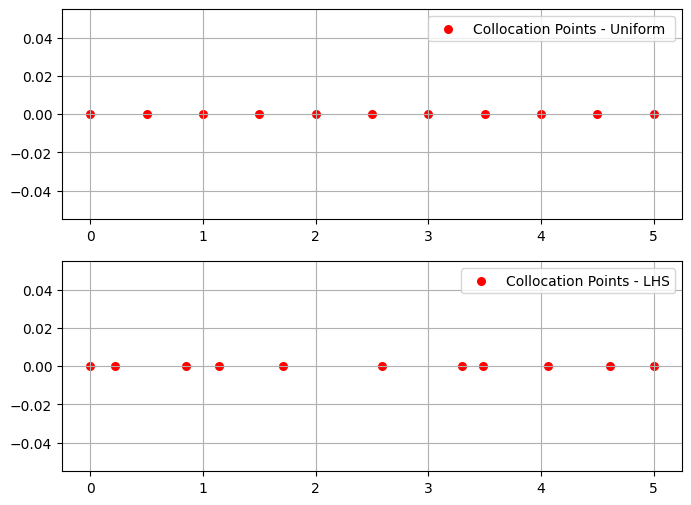

In [2]:
# Criar um amostrador LHS
n_samples = 9  # Número de pontos desejados sem considerar o extremo
t_min, t_max = 0, 5  # Intervalo de amostragem
sampler = qmc.LatinHypercube(d=1,seed = 40)  # d=1 porque queremos uma dimensão
tempo1 = qmc.scale(sampler.random(n=n_samples), t_min, t_max) # Gerar amostras e escalá-las para o intervalo desejado
tempo1 = tempo1.ravel()                       # Transformar em vetor unidimensional
tempo = np.hstack(([t_min], tempo1, [t_max])) # Adicionar os pontos inicial e final
tempo.sort() # Ordenar os valores
pontos_colocacao4 = np.zeros(n_samples+2)     # Pontos de colocacao
tempo2 = np.linspace(t_min,t_max,n_samples+2)

fig, axs = plt.subplots(2, 1, figsize=(8, 6))

axs[0].scatter(tempo2,pontos_colocacao4,c='r',marker='o',s=30,label='Collocation Points - Uniform ')
axs[0].grid('True')
axs[0].legend()

axs[1].scatter(tempo,pontos_colocacao4,c='r',marker='o',s=30,label='Collocation Points - LHS')
axs[1].grid('True')
axs[1].legend()

plt.savefig("coloc_points.pdf", format="pdf", bbox_inches="tight")
plt.show()

# Minha PINN 4 - Estudo de Caso 1

Problema de um circuito RL (resistência - indutor)
$$ L \frac{dI}{dt} + RI = E$$

Para o exercicio em questão:
$$R = 12 [\Omega] \hspace{1cm} L = 4[H] \hspace{1cm} E = 60[V] \hspace{1cm} I(0) = 0$$

A solução analitica do problema é equivalente a:
$$I(t) = 5 - 5 e^{-3t}$$

In [ ]:
# Lx' + Rx - E = 0  x(0) = 0
func4_grad_x = grad(my_NN,0)        #derivada da rede em relacao a x
def my_pinn4(params):
  n_samples = 9  # Número de pontos desejados sem considerar o extremo
  t_min, t_max = 0, 5  # Intervalo de amostragem
  # Criar um amostrador LHS
  sampler = qmc.LatinHypercube(d=1,seed = 40)  # d=1 porque queremos uma dimensão
  tempo1 = qmc.scale(sampler.random(n=n_samples), t_min, t_max) # Gerar amostras e escalá-las para o intervalo desejado
  tempo1 = tempo1.ravel()                       # Transformar em vetor unidimensional
  tempo = np.hstack(([t_min], tempo1, [t_max])) # Adicionar os pontos inicial e final
  tempo.sort() # Ordenar os valores

  #tempo = np.linspace(0,1,num=101)  #tempo definido com espacamento igual
  loss_cc = 0                        #valor inicial da loss das condicoes de contorno
  loss_edo = 0                       #valor inicial da loss da EDO
  ####################################
  x0 = 0      # condicao de contorno do problema
  R = 12      # Resistencia
  L = 4       # Indutancia
  E = 60      # Tensao
  ###################################
  for t in tempo:
    X = my_NN(t, params,N_INPUT,N_OUTPUT,N_NEURON,N_HIDDEN)
    func_x = func4_grad_x(t, params,N_INPUT,N_OUTPUT,N_NEURON,N_HIDDEN)
    if t == 0:
      loss_cc = (-X[0] + x0)**2
    else:
      loss_edo = loss_edo + (L*func_x + R*X[0] - E)**2

  L = loss_cc + (loss_edo / np.size(tempo))
  return L

### Resolucao em loop

In [ ]:
# Dados Globais
# EXCELENTES RESULTADOS COM 4 NEURONIOS, 1 CAMADA, 2O MEMBROS, 200 ITERACOES, SIGMOID
I_max=200;			# Maximum iteration
M=20;				    # Number of Particle/population/ecosize/agentes
N_HIDDEN = 1    # numero de camadas escondidas
N_NEURON = 4    # numero de neuronios por camada escondida (numero fixo nas camadas)
N_INPUT = 1     # valores na entrada
N_OUTPUT = 1    # valores na saida

#Parâmetros da Meta-Heuristica
F = 0.7;      # Scaling factor F         - DE
CR = 0.9;     # Crossover factor CR      - DE

dim = total_paramns(N_INPUT,N_OUTPUT,N_NEURON,N_HIDDEN)
N = dim
a, b = -10, 10          # Intervalo desejado
x = np.zeros((M, dim))  # iniciando o vetor de variaveis

Func=my_pinn4;                                   # PROBLEMA QUE SERA RESOLVIDO
FA1=0;                                           # function evaluation counter
fitinho = []                                     # vetor que acumula os resultados iniciais
for i in range(M):                               # Personal best initialize
    x[i, :] = np.random.uniform(a, b, (1, dim))  # Inicializa a posição do i-ésimo indivíduo
    params = np.array(x[i].tolist())
    fitinho.append(Func(params))

Fit = np.array(fitinho) #vetor acumulado convertido para array

# Dados para a solucao analitica
tempo4 = np.linspace(0,5.0,num=301)
R = 12
I0 = 0
L = 4
E = 60
x_analitico4 = E/R - ((E-R*I0)/R)*np.exp(-(R/L)*tempo4)

# Vetores acumulativos para solucoes e metricas
R2_4 = []
RMSE_4 = []
MAE_4 = []
All_Y = []
All_Gb = []
All_curva = []
lista_x_pinn4 = []

# Número de execuções para repetibilidade
n_realizacoes = 30

for _ in range(n_realizacoes):
  [Y,Gb,curva]=DE_alg(Func, b, a, N, M, I_max,F,CR,x,Fit);
  All_Y.append(Y)
  All_Gb.append(Gb)
  All_curva.append(curva)
  X = []
  for t in tempo4:
      X.append(my_NN(t, Gb,N_INPUT,N_OUTPUT,N_NEURON,N_HIDDEN))

  x_pinn4 = np.concatenate(X)
  lista_x_pinn4.append(x_pinn4)

  # CORRELACAO R2
  r24 = r2_score(x_analitico4, x_pinn4)
  R2_4.append(r24)

  # RAIZ DO ERRO QUADRATICO MEDIO
  rmse4 = np.sqrt(mean_squared_error(x_analitico4, x_pinn4))  # (RMSE)
  RMSE_4.append(rmse4)

  # ERRO MEDIO ABSOLUTO
  mae4 = mean_absolute_error(x_analitico4, x_pinn4)
  MAE_4.append(mae4)



## Grafico da Solucao PINN e Exata

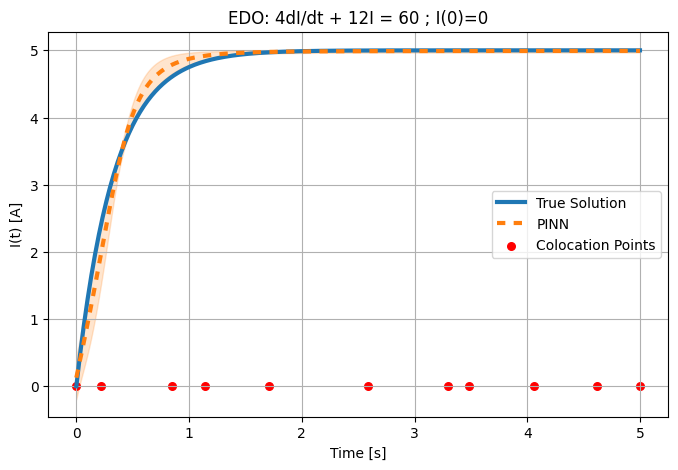

In [ ]:
#import numpy as np
import pandas as pd
import seaborn as sns
#import matplotlib.pyplot as plt
# Converter os resultados para um DataFrame
df = pd.DataFrame({
    'Tempo': np.tile(tempo4, n_realizacoes),
    'x_pinn4': np.hstack(lista_x_pinn4),
    'Realizacao': np.repeat(range(1, n_realizacoes + 1), len(tempo4))
})

n_samples = 9  # Número de pontos desejados sem considerar o extremo
t_min, t_max = 0, 5  # Intervalo de amostragem
# Criar um amostrador LHS
sampler = qmc.LatinHypercube(d=1,seed = 40)  # d=1 porque queremos uma dimensão
tempo1 = qmc.scale(sampler.random(n=n_samples), t_min, t_max) # Gerar amostras e escalá-las para o intervalo desejado
tempo1 = tempo1.ravel()                       # Transformar em vetor unidimensional
tempo = np.hstack(([t_min], tempo1, [t_max])) # Adicionar os pontos inicial e final
tempo.sort() # Ordenar os valores
pontos_colocacao4 = np.zeros(n_samples+2)     # Pontos de colocacao

# Criar a figura
plt.figure(figsize=(8, 5))
plt.plot(tempo4, x_analitico4, label='True Solution', linewidth=3)
sns.lineplot(data=df, x='Tempo', y='x_pinn4', errorbar='sd', label='PINN',linewidth=3,dashes=(2, 2))
plt.scatter(tempo,pontos_colocacao4,c='r',marker='o',s=30,label='Colocation Points')

plt.xlabel('Time [s]')
plt.ylabel('I(t) [A]')
plt.title('EDO: 4dI/dt + 12I = 60 ; I(0)=0')
plt.grid()
plt.legend()
plt.savefig("pinn4.pdf", format="pdf", bbox_inches="tight")
plt.show()


### Metricas para o Case 1 - PINN 4

In [ ]:
# print(f'{np.array(All_Y)}')
# print(f'{np.array(All_Gb)}')
#print(np.array(All_curva))
print('Melhor Valor das Metricas')
print(f'{np.max(np.array(R2_4))}')
print(f'{np.min(np.array(RMSE_4))}')
print(np.min(np.array(MAE_4)))
print(' ')
print('Pior Valor das Metricas')
print(f'{np.min(np.array(R2_4))}')
print(f'{np.max(np.array(RMSE_4))}')
print(np.max(np.array(MAE_4)))
print(' ')
print('Medias das Metricas')
print(f'{np.mean(np.array(R2_4))}')
print(f'{np.mean(np.array(RMSE_4))}')
print(np.mean(np.array(MAE_4)))
print(' ')
print('Desvio Padrão das Metricas')
print(f'{np.std(np.array(R2_4))}')
print(f'{np.std(np.array(RMSE_4))}')
print(np.std(np.array(MAE_4)))

Melhor Valor das Metricas
0.999703846791655
0.01497069495798979
0.00739541937112403
 
Pior Valor das Metricas
0.8920194340533437
0.28586207382223355
0.1265868829224195
 
Medias das Metricas
0.9637764571319597
0.14285686284616544
0.0701488882066817
 
Desvio Padrão das Metricas
0.0349636442525646
0.08369607413588828
0.0373895759836135


### Plotagem da curva de convergencia

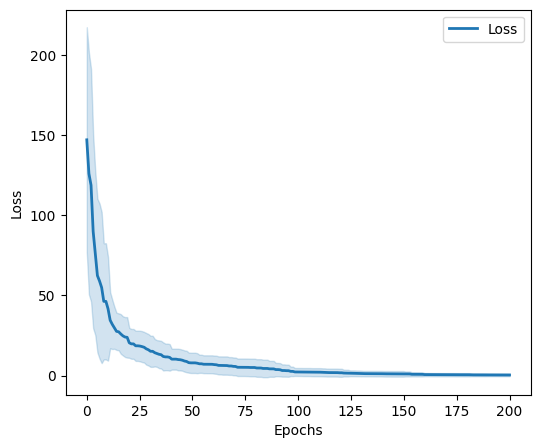

In [ ]:
iteracoes = np.linspace(0,I_max,np.size(curva))
# Converter os resultados para um DataFrame
df_loss = pd.DataFrame({
    'Tempo_loss': np.tile(iteracoes, n_realizacoes),
    'Y_loss': np.hstack(All_curva),
    'Realizacao': np.repeat(range(1, n_realizacoes + 1), len(iteracoes))
})

# Criar a figura
plt.figure(figsize=(6, 5))
sns.lineplot(data=df_loss, x='Tempo_loss', y='Y_loss', errorbar='sd', label='Loss',linewidth=2)

plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.title('Convergencia Loss')
#plt.grid()
plt.legend()
plt.savefig("loss4.pdf", format="pdf", bbox_inches="tight")
plt.show()

# Minha PINN 5

Problema de um circuito RL (resistência - indutor)
$$ L \frac{dI}{dt} + RI = E$$

Para o exercicio em questão:
$$R = 20 [\Omega] \hspace{1cm} L = 4[H] \hspace{1cm} E = 0[V] \hspace{1cm} I(0) = 8$$

A solução analitica do problema é equivalente a:
$$I(t) =  0.4 e^{-5t}$$

In [ ]:
# Lx' + Rx - E = 0  x(0) = 0
func5_grad_x = grad(my_NN,0)        #derivada da rede em relacao a x
def my_pinn5(params):
  n_samples = 9  # Número de pontos desejados sem considerar o extremo
  t_min, t_max = 0, 1  # Intervalo de amostragem
  # Criar um amostrador LHS
  sampler = qmc.LatinHypercube(d=1,seed = 40)  # d=1 porque queremos uma dimensão
  tempo1 = qmc.scale(sampler.random(n=n_samples), t_min, t_max) # Gerar amostras e escalá-las para o intervalo desejado
  tempo1 = tempo1.ravel()                       # Transformar em vetor unidimensional
  tempo = np.hstack(([t_min], tempo1, [t_max])) # Adicionar os pontos inicial e final
  tempo.sort() # Ordenar os valores

  #tempo = np.linspace(0,1,num=101)  #tempo definido com espacamento igual
  loss_cc = 0                        #valor inicial da loss das condicoes de contorno
  loss_edo = 0                       #valor inicial da loss da EDO
  ####################################
  # configuracao sem tensao inicial e com corrente inicial
  x0 = 8                             #condicao de contorno do problema
  R = 20      # Resistencia
  L = 4       # Indutancia
  E = 0      # Tensao
  ###################################
  for t in tempo:
    X = my_NN(t, params,N_INPUT,N_OUTPUT,N_NEURON,N_HIDDEN)
    func_x = func5_grad_x(t, params,N_INPUT,N_OUTPUT,N_NEURON,N_HIDDEN)
    if t == 0:
      loss_cc = (-X[0] + x0)**2
    else:
      loss_edo = loss_edo + (L*func_x + R*X[0] - E)**2

  L = loss_cc + (loss_edo / np.size(tempo))
  return L

### Resolucao em loop


In [ ]:
tempo5 = np.linspace(0,1.0,num=301)
I0 = 8      #condicao de contorno do problema
R = 20      # Resistencia
L = 4       # Indutancia
E = 0       # Tensao
x_analitico5 = E/R - ((E-R*I0)/R)*np.exp(-(R/L)*tempo5)

R2_5 = []
RMSE_5 = []
MAE_5 = []
All_Y5 = []
All_Gb5 = []
All_curva5 = []
lista_x_pinn5 = []

# Dados Globais
# EXCELENTES RESULTADOS COM 4 NEURONIOS, 1 CAMADA, 2O MEMBROS, 200 ITERACOES, SIGMOID
I_max=200;			# Maximum iteration
M=20;				    # Number of Particle/population/ecosize/agentes
N_HIDDEN = 1    # numero de camadas escondidas
N_NEURON = 4    # numero de neuronios por camada escondida (numero fixo nas camadas)
N_INPUT = 1     # valores na entrada
N_OUTPUT = 1    # valores na saida

dim = total_paramns(N_INPUT,N_OUTPUT,N_NEURON,N_HIDDEN)
N = dim
a, b = -10, 10          # Intervalo desejado
x = np.zeros((M, dim))  # iniciando o vetor de variaveis
#params = np.random.uniform(a, b, (1, dim))  # Gera números entre 'a' e 'b'

Func=my_pinn5;     # PROBLEMA QUE SERA RESOLVIDO
FA1=0;            # function evaluation counter
fitinho = []      # vetor que acumula os resultados iniciais
for i in range(M): # Personal best initialize
    x[i, :] = np.random.uniform(a, b, (1, dim))  # Inicializa a posição do i-ésimo indivíduo
    # v[i, :] = V_min + np.random.rand(1, N) * (V_max - V_min)  # Inicializa a velocidade do i-ésimo indivíduo
    params = np.array(x[i].tolist())
    fitinho.append(Func(params))

#Parâmetros do Algoritmo
F = 0.7;      # Scaling factor F         - DE
CR = 0.9;     # Crossover factor CR      - DE
Fit = np.array(fitinho) #vetor acumulado convertido para array

# Número de execuções para diferentes Gb
n_realizacoes = 30
Func = my_pinn5
for _ in range(n_realizacoes):
  [Y,Gb,curva]=DE_alg(Func, b, a, N, M, I_max,F,CR,x,Fit);
  All_Y5.append(Y)
  All_Gb5.append(Gb)
  All_curva5.append(curva)
  X = []
  for t in tempo5:
      X.append(my_NN(t, Gb,N_INPUT,N_OUTPUT,N_NEURON,N_HIDDEN))

  x_pinn5 = np.concatenate(X)
  lista_x_pinn5.append(x_pinn5)

  # CORRELACAO R2
  r25 = r2_score(x_analitico5, x_pinn5)
  R2_5.append(r25)

  # RAIZ DO ERRO QUADRATICO MEDIO
  rmse5 = np.sqrt(mean_squared_error(x_analitico5, x_pinn5))  # (RMSE)
  RMSE_5.append(rmse5)

  # ERRO MEDIO ABSOLUTO
  mae5 = mean_absolute_error(x_analitico5, x_pinn5)
  MAE_5.append(mae5)


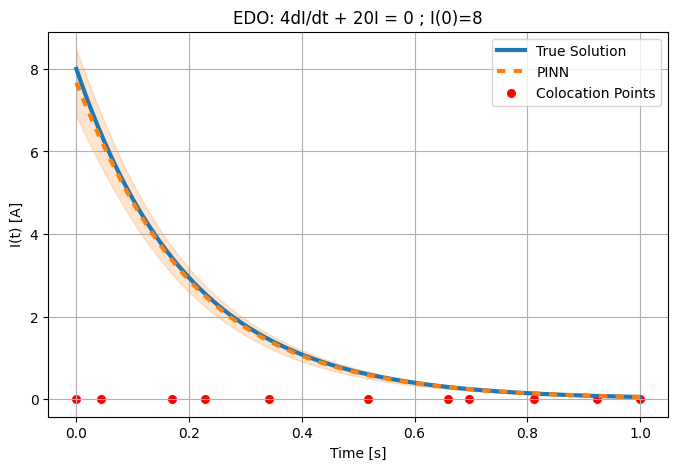

In [ ]:
import pandas as pd
import seaborn as sns
# Converter os resultados para um DataFrame
df = pd.DataFrame({
    'Tempo': np.tile(tempo5, n_realizacoes),
    'x_pinn5': np.hstack(lista_x_pinn5),
    'Realizacao': np.repeat(range(1, n_realizacoes + 1), len(tempo5))
})

n_samples = 9  # Número de pontos desejados sem considerar o extremo
t_min, t_max = 0, 1  # Intervalo de amostragem
# Criar um amostrador LHS
sampler = qmc.LatinHypercube(d=1,seed = 40)  # d=1 porque queremos uma dimensão
tempo1 = qmc.scale(sampler.random(n=n_samples), t_min, t_max) # Gerar amostras e escalá-las para o intervalo desejado
tempo1 = tempo1.ravel()                       # Transformar em vetor unidimensional
tempo = np.hstack(([t_min], tempo1, [t_max])) # Adicionar os pontos inicial e final
tempo.sort() # Ordenar os valores
pontos_colocacao5 = np.zeros(n_samples+2)     # Pontos de colocacao

# Criar a figura
plt.figure(figsize=(8, 5))
plt.plot(tempo5, x_analitico5, label='True Solution', linewidth=3)
sns.lineplot(data=df, x='Tempo', y='x_pinn5', errorbar='sd', label='PINN',linewidth=3,dashes=(2, 2))
plt.scatter(tempo,pontos_colocacao5,c='r',marker='o',s=30,label='Colocation Points')

plt.xlabel('Time [s]')
plt.ylabel('I(t) [A]')
plt.title('EDO: 4dI/dt + 20I = 0 ; I(0)=8')
plt.grid()
plt.legend()
plt.savefig("pinn5.pdf", format="pdf", bbox_inches="tight")
plt.show()

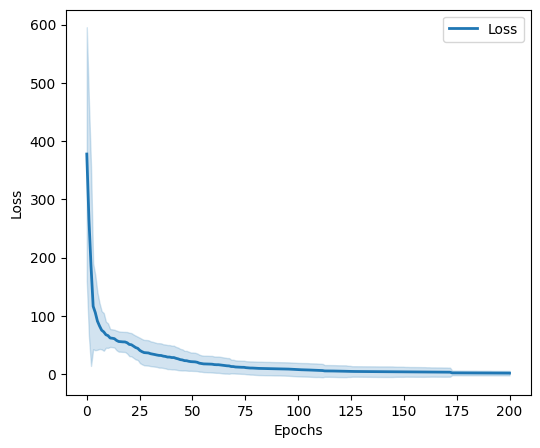

In [ ]:
iteracoes = np.linspace(0,I_max,np.size(curva))
# Converter os resultados para um DataFrame
df_loss = pd.DataFrame({
    'Tempo_loss': np.tile(iteracoes, n_realizacoes),
    'Y_loss': np.hstack(All_curva5),
    'Realizacao': np.repeat(range(1, n_realizacoes + 1), len(iteracoes))
})

# Criar a figura
plt.figure(figsize=(6, 5))
sns.lineplot(data=df_loss, x='Tempo_loss', y='Y_loss', errorbar='sd', label='Loss',linewidth=2)

plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.title('Convergencia Loss')
#plt.grid()
plt.legend()
plt.savefig("loss5.pdf", format="pdf", bbox_inches="tight")
plt.show()

### Metricas Case 2 - PINN 5

In [ ]:
print('Melhor Resultado')
print(f'{np.max(np.array(R2_5))}')
print(f'{np.min(np.array(RMSE_5))}')
print(np.min(np.array(MAE_5)))
print(' ')

print('Pior Resultado')
print(f'{np.min(np.array(R2_5))}')
print(f'{np.max(np.array(RMSE_5))}')
print(np.max(np.array(MAE_5)))
print(' ')

print('Media Resultado')
print(f'{np.mean(np.array(R2_5))}')
print(f'{np.mean(np.array(RMSE_5))}')
print(np.mean(np.array(MAE_5)))
print(' ')

print('Desvio Padrao Resultado')
print(f'{np.std(np.array(R2_5))}')
print(f'{np.std(np.array(RMSE_5))}')
print(np.std(np.array(MAE_5)))

Melhor Resultado
0.9999085145202307
0.018970683103016046
0.009419836658889447
 
Pior Resultado
0.7710963983402965
0.9489278599940224
0.6371847212824967
 
Media Resultado
0.9830953099685171
0.12130406060152756
0.0782135084898408
 
Desvio Padrao Resultado
0.05145290239805256
0.22756366826630647
0.14873919814676292


## Referenciar o texto

```{bibliography}
@unpublished{PSS2025,
  author = {Paulo de Souza Silva},
  title = {Aplicação do Evolução Diferencial na otimização de PINNs para solução de circuitos RL},
  note = {Artigo em processo de avaliação},
  year = {2025}
}
